A notebook for processing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

Processin of data captured on 22/05/2023 - repeated at 12-bit resolution.

# Process Overview

The objective of this notebook is to process uniformly illuminated and dark images (across the sampling area) and characterise each camera of the OROCHI simulator, in terms of:
- Linearity
- Read Noise
- Gain
- FPN
- Dark Signal

To do this, we will process images of the 99% Reflectance Spectralon Calibration Target (SCT99) and the 5% Reflectance Spectral Calibration Target (SCT5), and images without illumination, at exposures that range from the minimum possible with the cameras (~5 µs) up to a maximum, defined such that all pixels of the image are saturated (DN=255).

For each of the SCT99 and SCT5 targets, we:
- for each channel:
    - load the list of exposures
    - for each exposure,
        - load image 1
        - load image 2
        - load the dark frame
        - get mean of image 1 - dark
        - get the noise of image 1 - dark
        - get the noise of image 1 - image 2
    - plot mean vs exposure
    - plot noise vs mean
    - plot ∆noise vs mean
    - get the read noise
    - get shot noise
    - plot shot noise vs mean
    - get sensitivity
    - plot sensitivity vs mean
    - evaluate linearity

As we'd like to repeat this for each camera, we will write each of these steps into functions, contained in the notebook here, such that the analysis can be iterated and automated.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# PCT99

Here we process the PTC (Photon Transfer Curve) data for each channel in turn.


--------------------------------------------
Processing SCT99/0_650
Loaded images (650_104us_1_calibration) for: 0 (650 nm)
Loaded images (650_104us_2_calibration) for: 0 (650 nm)
Loaded images (650_104us_d_drk) for: 0 (650 nm)
Loaded images (650_1109us_1_calibration) for: 0 (650 nm)
Loaded images (650_1109us_2_calibration) for: 0 (650 nm)
Loaded images (650_1109us_d_drk) for: 0 (650 nm)
Loaded images (650_124us_1_calibration) for: 0 (650 nm)
Loaded images (650_124us_2_calibration) for: 0 (650 nm)
Loaded images (650_124us_d_drk) for: 0 (650 nm)
Loaded images (650_1331us_1_calibration) for: 0 (650 nm)
Loaded images (650_1331us_2_calibration) for: 0 (650 nm)
Loaded images (650_1331us_d_drk) for: 0 (650 nm)
Loaded images (650_149us_1_calibration) for: 0 (650 nm)
Loaded images (650_149us_2_calibration) for: 0 (650 nm)
Loaded images (650_149us_d_drk) for: 0 (650 nm)
Loaded images (650_1597us_1_calibration) for: 0 (650 nm)
Loaded images (650_1597us_2_calibration) for: 0 (650 nm)
Loaded image

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------------------------------
--------------------------------------------
Processing SCT99/1_475
Loaded images (475_10019us_1_calibration) for: 1 (475 nm)
Loaded images (475_10019us_2_calibration) for: 1 (475 nm)
Loaded images (475_10019us_d_drk) for: 1 (475 nm)
Loaded images (475_10121us_1_calibration) for: 1 (475 nm)
Loaded images (475_10121us_2_calibration) for: 1 (475 nm)
Loaded images (475_10121us_d_drk) for: 1 (475 nm)
Loaded images (475_10223us_1_calibration) for: 1 (475 nm)
Loaded images (475_10223us_2_calibration) for: 1 (475 nm)
Loaded images (475_10223us_d_drk) for: 1 (475 nm)
Loaded images (475_10326us_1_calibration) for: 1 (475 nm)
Loaded images (475_10326us_2_calibration) for: 1 (475 nm)
Loaded images (475_10326us_d_drk) for: 1 (475 nm)
Loaded images (475_10430us_1_calibration) for: 1 (475 nm)
Loaded images (475_10430us_2_calibration) for: 1 (475 nm)
Loaded images (475_10430us_d_drk) for: 1 (475 nm)
Loaded images (475_104us_1_calibration) for: 1 (475 nm)
L

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------------------------------
--------------------------------------------
Processing SCT99/3_400
Loaded images (400_104us_1_calibration) for: 3 (400 nm)
Loaded images (400_104us_2_calibration) for: 3 (400 nm)
Loaded images (400_104us_d_drk) for: 3 (400 nm)
Loaded images (400_1109us_1_calibration) for: 3 (400 nm)
Loaded images (400_1109us_2_calibration) for: 3 (400 nm)
Loaded images (400_1109us_d_drk) for: 3 (400 nm)
Loaded images (400_11869us_1_calibration) for: 3 (400 nm)
Loaded images (400_11869us_2_calibration) for: 3 (400 nm)
Loaded images (400_11869us_d_drk) for: 3 (400 nm)
Loaded images (400_124us_1_calibration) for: 3 (400 nm)
Loaded images (400_124us_2_calibration) for: 3 (400 nm)
Loaded images (400_124us_d_drk) for: 3 (400 nm)
Loaded images (400_1331us_1_calibration) for: 3 (400 nm)
Loaded images (400_1331us_2_calibration) for: 3 (400 nm)
Loaded images (400_1331us_d_drk) for: 3 (400 nm)
Loaded images (400_14243us_1_calibration) for: 3 (400 nm)
Loaded images (40

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------------------------------
--------------------------------------------
Processing SCT99/4_725
Loaded images (725_104us_1_calibration) for: 4 (725 nm)
Loaded images (725_104us_2_calibration) for: 4 (725 nm)
Loaded images (725_104us_d_drk) for: 4 (725 nm)
Loaded images (725_1109us_1_calibration) for: 4 (725 nm)
Loaded images (725_1109us_2_calibration) for: 4 (725 nm)
Loaded images (725_1109us_d_drk) for: 4 (725 nm)
Loaded images (725_124us_1_calibration) for: 4 (725 nm)
Loaded images (725_124us_2_calibration) for: 4 (725 nm)
Loaded images (725_124us_d_drk) for: 4 (725 nm)
Loaded images (725_1331us_1_calibration) for: 4 (725 nm)
Loaded images (725_1331us_2_calibration) for: 4 (725 nm)
Loaded images (725_1331us_d_drk) for: 4 (725 nm)
Loaded images (725_149us_1_calibration) for: 4 (725 nm)
Loaded images (725_149us_2_calibration) for: 4 (725 nm)
Loaded images (725_149us_d_drk) for: 4 (725 nm)
Loaded images (725_1597us_1_calibration) for: 4 (725 nm)
Loaded images (725_1597u

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_4521/2402135859.py:48: RuntimeWarning: divide by zero encountered in divide
  drs.append(20.0*np.log10(full_well/read_noise))
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------------------------------
--------------------------------------------
Processing SCT99/5_850
Loaded images (850_104us_1_calibration) for: 5 (850 nm)
Loaded images (850_104us_2_calibration) for: 5 (850 nm)
Loaded images (850_104us_d_drk) for: 5 (850 nm)
Loaded images (850_1109us_1_calibration) for: 5 (850 nm)
Loaded images (850_1109us_2_calibration) for: 5 (850 nm)
Loaded images (850_1109us_d_drk) for: 5 (850 nm)
Loaded images (850_11869us_1_calibration) for: 5 (850 nm)
Loaded images (850_11869us_2_calibration) for: 5 (850 nm)
Loaded images (850_11869us_d_drk) for: 5 (850 nm)
Loaded images (850_124us_1_calibration) for: 5 (850 nm)
Loaded images (850_124us_2_calibration) for: 5 (850 nm)
Loaded images (850_124us_d_drk) for: 5 (850 nm)
Loaded images (850_1331us_1_calibration) for: 5 (850 nm)
Loaded images (850_1331us_2_calibration) for: 5 (850 nm)
Loaded images (850_1331us_d_drk) for: 5 (850 nm)
Loaded images (850_14243us_1_calibration) for: 5 (850 nm)
Loaded images (85

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------------------------------
--------------------------------------------
Processing SCT99/6_550
Loaded images (550_104us_1_calibration) for: 6 (550 nm)
Loaded images (550_104us_2_calibration) for: 6 (550 nm)
Loaded images (550_104us_d_drk) for: 6 (550 nm)
Loaded images (550_1109us_1_calibration) for: 6 (550 nm)
Loaded images (550_1109us_2_calibration) for: 6 (550 nm)
Loaded images (550_1109us_d_drk) for: 6 (550 nm)
Loaded images (550_124us_1_calibration) for: 6 (550 nm)
Loaded images (550_124us_2_calibration) for: 6 (550 nm)
Loaded images (550_124us_d_drk) for: 6 (550 nm)
Loaded images (550_1331us_1_calibration) for: 6 (550 nm)
Loaded images (550_1331us_2_calibration) for: 6 (550 nm)
Loaded images (550_1331us_d_drk) for: 6 (550 nm)
Loaded images (550_149us_1_calibration) for: 6 (550 nm)
Loaded images (550_149us_2_calibration) for: 6 (550 nm)
Loaded images (550_149us_d_drk) for: 6 (550 nm)
Loaded images (550_1597us_1_calibration) for: 6 (550 nm)
Loaded images (550_1597u

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------------------------------


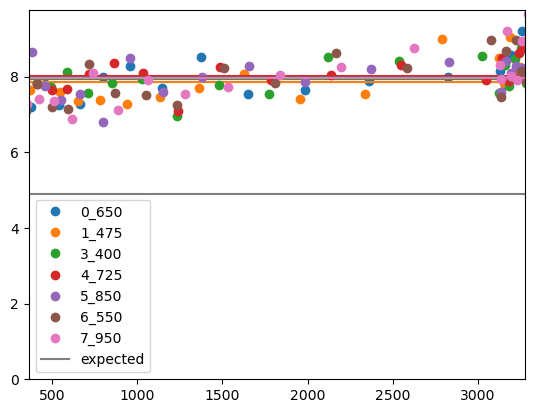

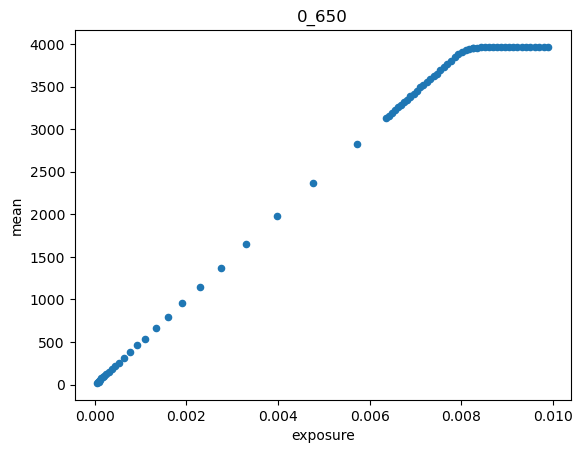

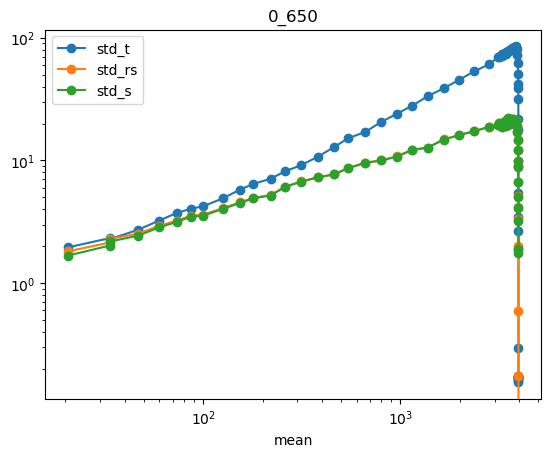

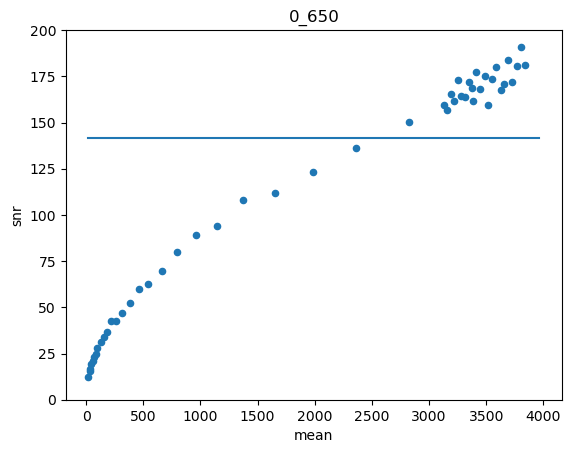

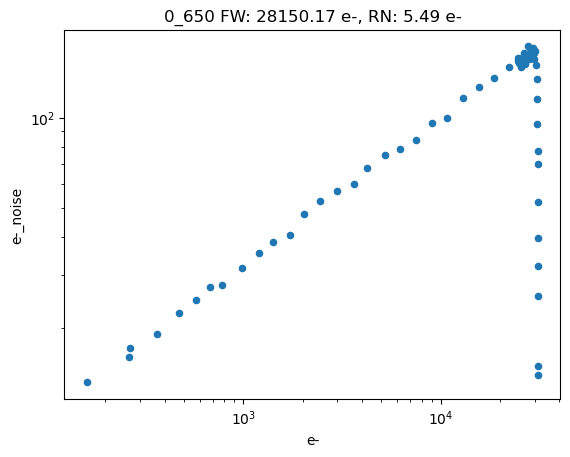

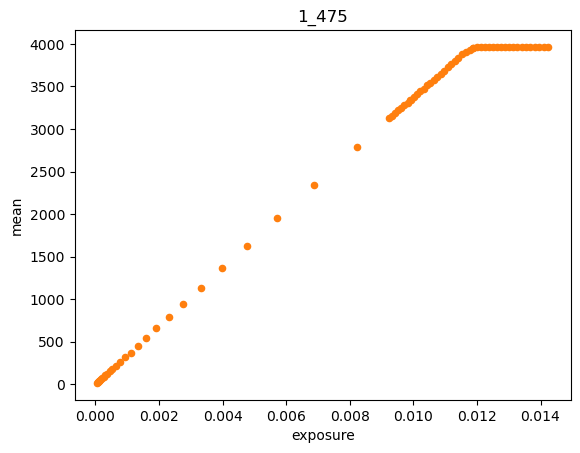

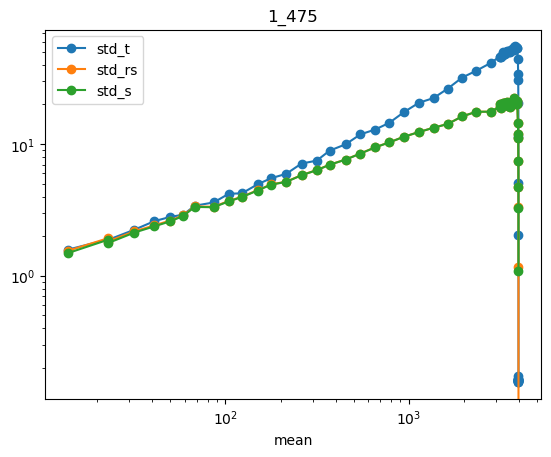

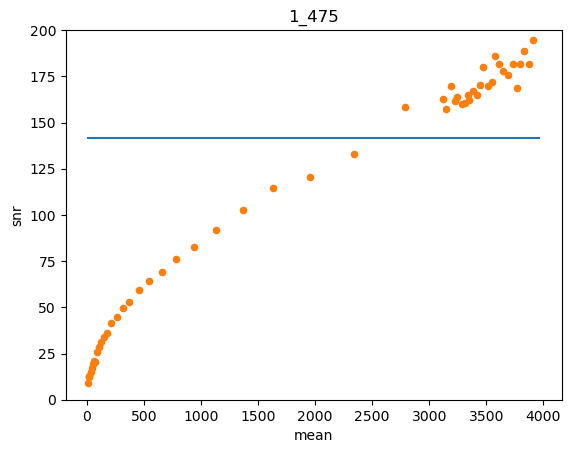

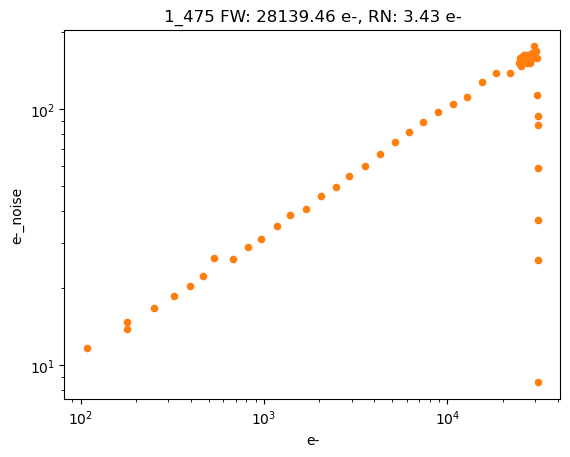

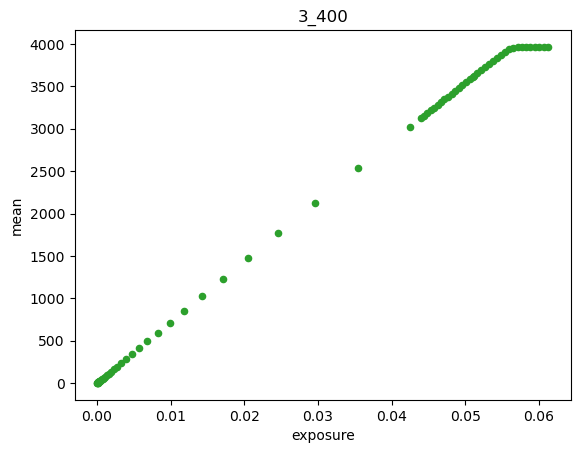

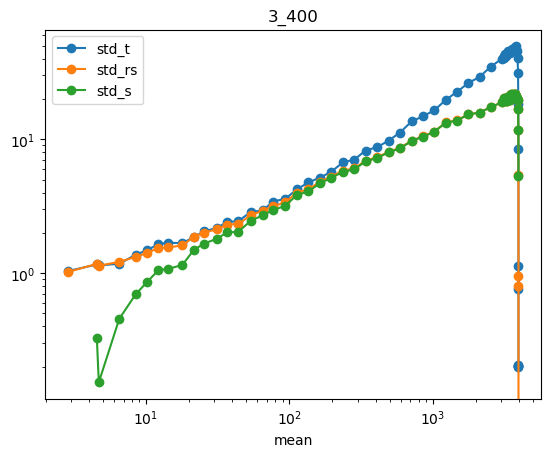

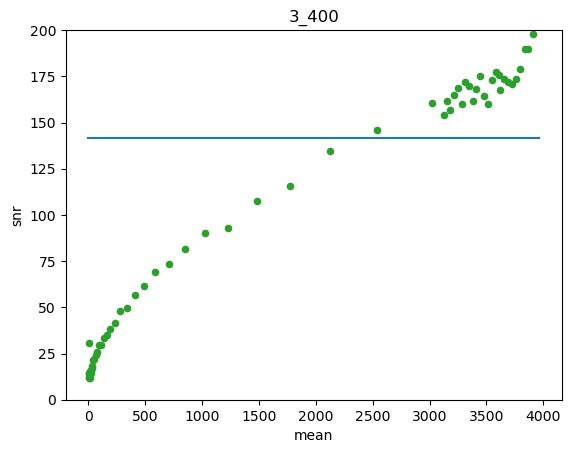

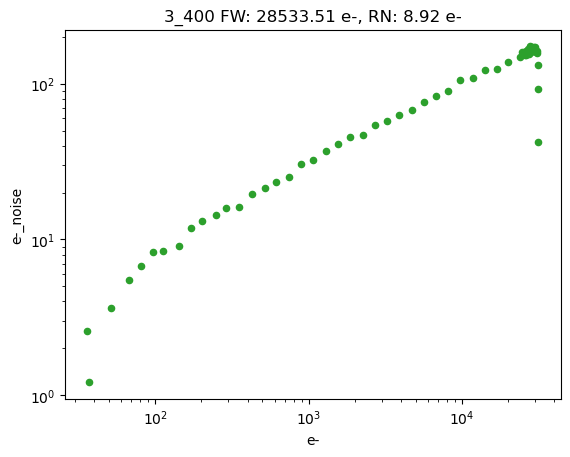

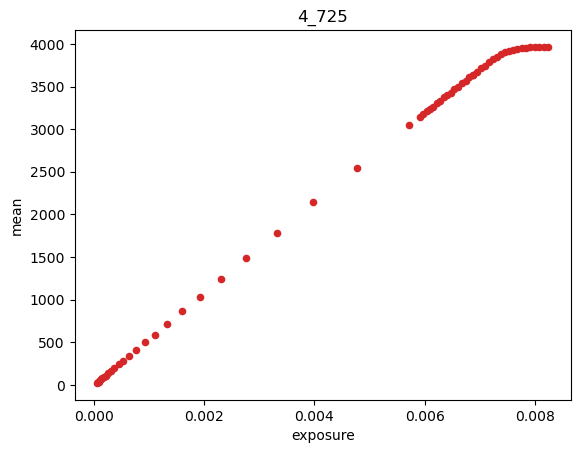

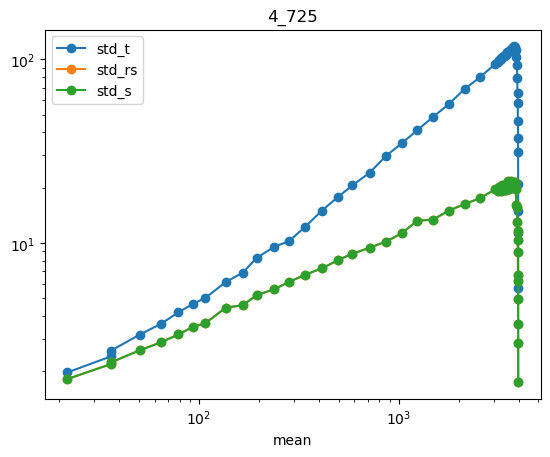

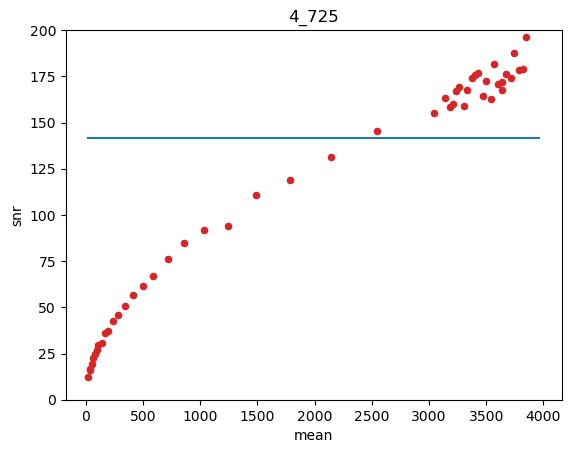

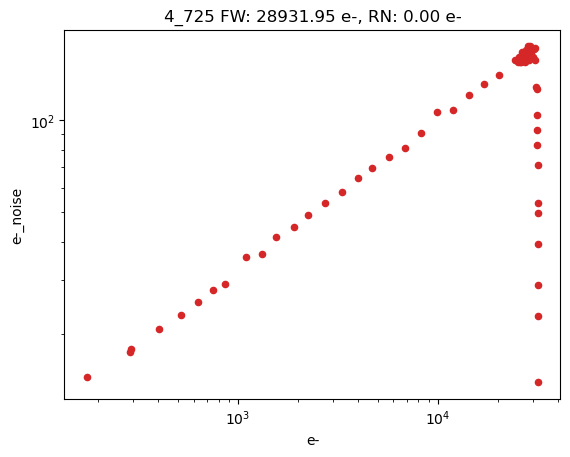

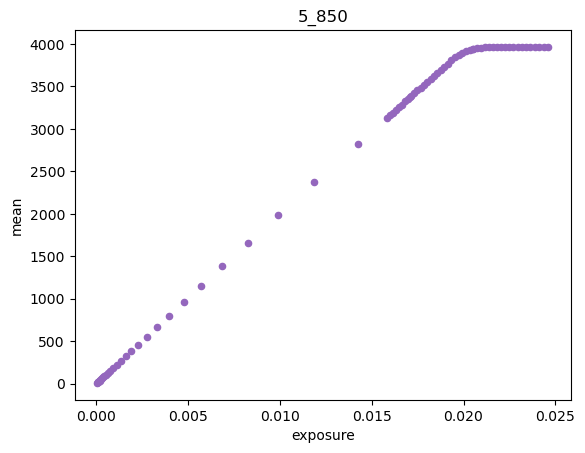

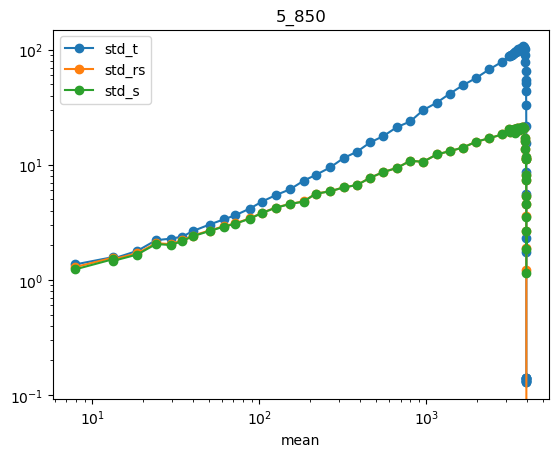

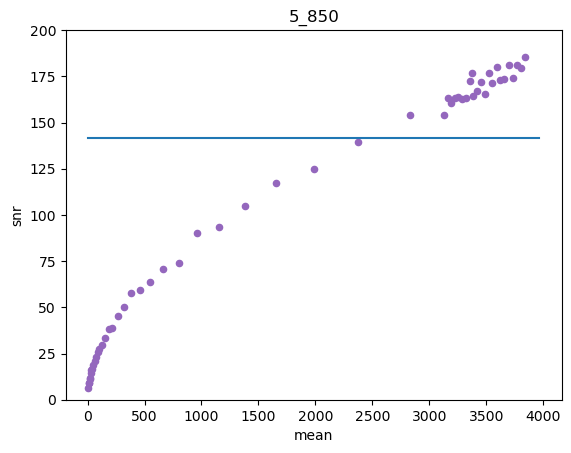

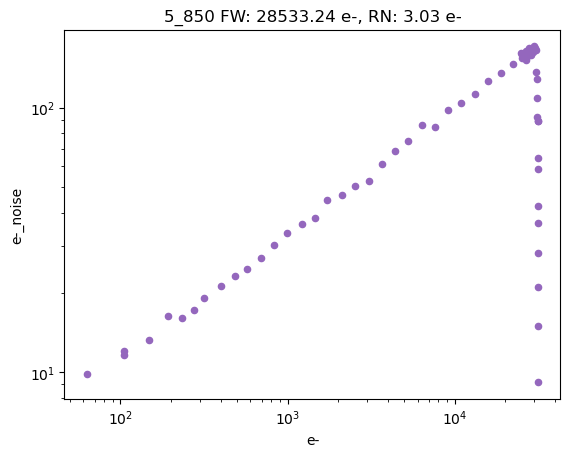

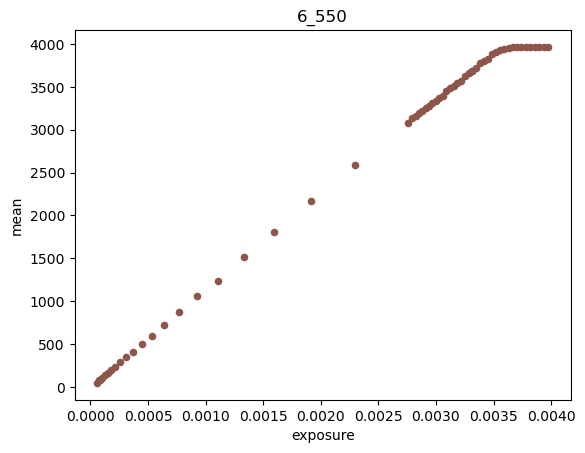

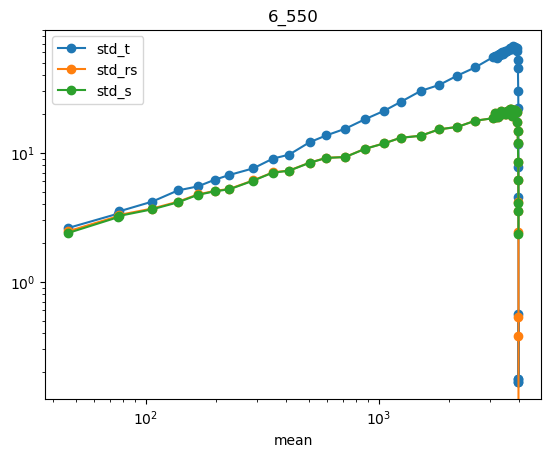

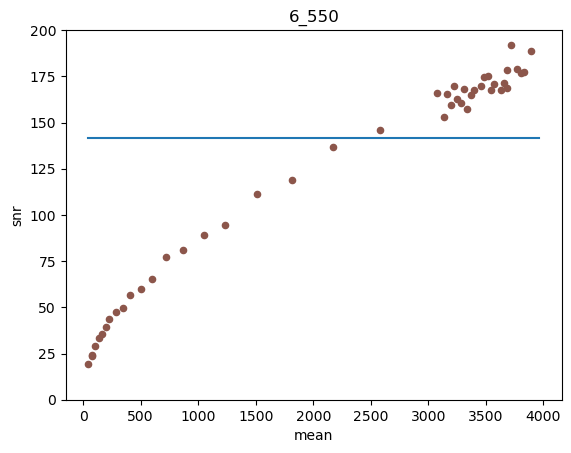

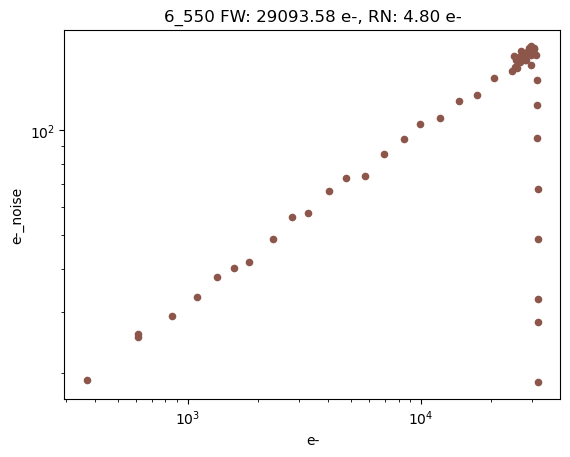

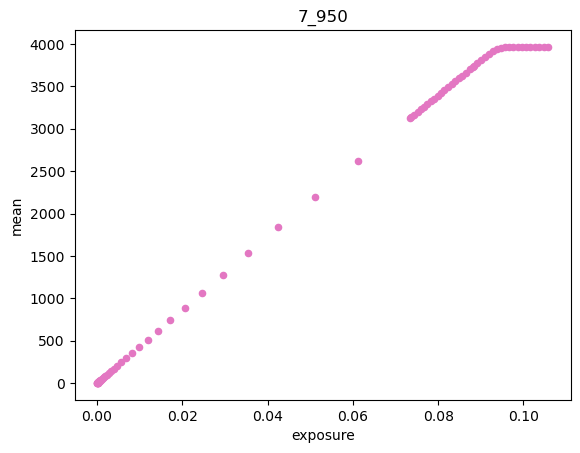

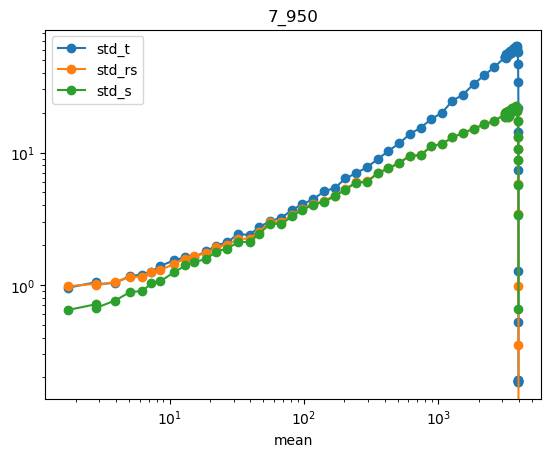

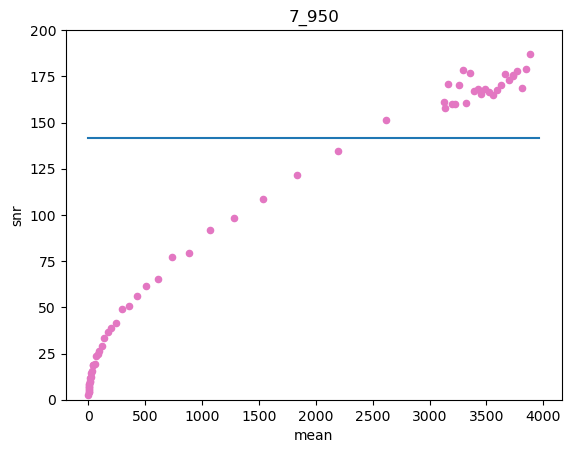

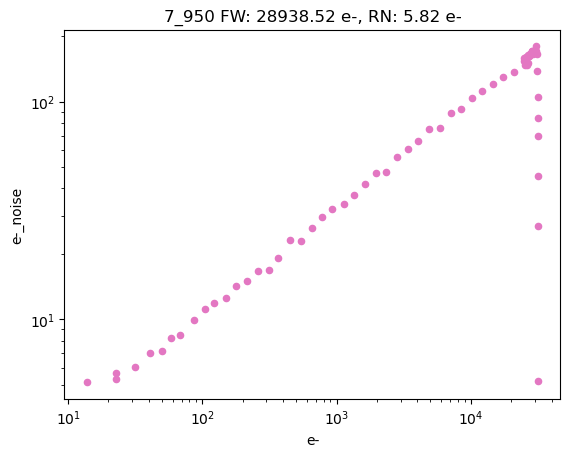

In [30]:
from pathlib import Path
import orochi_sim_proc as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# get list of channels
subject = 'SCT99'
channels = sorted(list(Path('..', 'data', subject).glob('[!.]*')))

fig, ax = plt.subplots() # init the grouped k_adc plot

k_adc_exp = 20000.0 / 2**12 # expected sensitivity in 12-bit mode for orochi
snr_peak_exp = 20000.0 / np.sqrt(20000.0)

k_adcs = []
full_wells = []
read_noises = []
drs = []

for channel_path in channels:
    channel = channel_path.name
    print('--------------------------------------------')
    print(f'Processing {subject}/{channel}')
    # load the calibration target images, and compute the full well and linear sensitivity
    pct_data, full_well, k_adc, read_noise = osp.load_pct_frames(subject, channel)
    # pct_data.sort_values('exposure', inplace=True)
    ax.plot(pct_data['mean'], pct_data['k_adc'], 'o', label=channel)
    # get colour
    colour = ax.get_lines()[-1].get_color()
    ax.plot(pct_data['mean'], k_adc+(0.0*pct_data['mean']), color=colour)
    ax.set_ylim(0, 2.0 * k_adc_exp)
    ax.set_xlim(0.1*full_well, 0.9*full_well)

    pct_data.plot.scatter('exposure', 'mean', title=channel, color=colour)
    pct_data.plot('mean', ['std_t', 'std_rs', 'std_s'], marker='o',logx=True, logy=True, title=channel)    
    # pct_data.plot.scatter('mean', 'std_t', title=channel)
    # pct_data.plot.scatter('mean','std_rs', title=channel)
    # pct_data.plot.scatter('mean','std_s', title=channel)    
    snr_ax = pct_data.plot.scatter('mean','snr', ylim=(0, 200), title=channel,color=colour)     
    snr_ax.plot(pct_data['mean'], snr_peak_exp+(0.0*pct_data['mean']))
    fw_str = f'{channel} FW: {full_well*k_adc:.2f} e-, RN: {k_adc*read_noise:.2f} e-'
    pct_data.plot.scatter('e-','e-_noise', logx=True, logy=True, title=fw_str, color=colour)         
    # pct_data.plot.scatter('mean','k_adc', ylim=(0, 2.0 * 30000.0 / 2**12))

    k_adcs.append(k_adc)
    full_wells.append(full_well*k_adc)
    read_noises.append(read_noise*k_adc)
    drs.append(20.0*np.log10(full_well/read_noise))
    print('--------------------------------------------')
    # print electron full well
# show legend
ax.plot(pct_data['mean'], k_adc_exp+(0.0*pct_data['mean']), label='expected')
ax.legend()
plt.show()

results = pd.DataFrame({'channel': channels, 'k_adc': k_adcs, 'full_well': full_wells, 'read_noise': read_noises, 'DR': drs})

In [29]:
results

,channel,k_adc,full_well,read_noise,DR
0,../data/SCT99/0_650,7.850702,28150.170988,5.486576,74.203593
1,../data/SCT99/1_475,7.854660,28139.460814,3.434554,78.268909
2,../data/SCT99/3_400,7.923923,28533.512058,8.916225,70.103484
3,../data/SCT99/4_725,8.006137,28931.951285,0.000000,inf
4,../data/SCT99/5_850,7.953091,28533.244907,3.034054,79.466556
5,../data/SCT99/6_550,7.990868,29093.582649,4.802902,75.645869
6,../data/SCT99/7_950,7.959433,28938.520511,5.817986,73.934073


Now we have this information, we need to properly compare it to the expectations of the OROCHI instrument, and scale accordingly.


First, we see that linearity is good over the 10 - 90 % response range - so we should keep the bias set as it is, and ensure that images are captured within this range.

Then, we need to make sure maximum SNR matches that of OROCHI, that we can achieve by limiting the electron count to the OROCHI Full Well, at 20000 e-.
This is approximately 2/3s of the detector response, ~2800 DN (12-bit mode).

But we also see from our SNR plots that the minimum SNR that we require occurs at ~2000 DN.

So this means we are aiming for an exposed region of ~2000 - 2800 DN, within the 12-bit window. This may be hard to achieve, if the dynamic range of the environment is much greater than this.
The best algorithm I think for achieving this is still the percentile algorithm, bbut greater guidance may be required to inform the number of pixels allowed to over expose. Or, we may need to do repeat imaging for the different targets, at different exposures.

SO what we need to do is allow for Auto-Exposure manual ROI selection.
- perform autoexposure on whole image / sample ROI
- select reference points
- re-run autoexposure on reference points
- set exposure for experiment
- repeat for a new reference point, and save etc.